In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import time
from rpy2 import robjects as ro
from rpy2.robjects import numpy2ri
from torch.distributions import Dirichlet, Multinomial
from scipy.io import loadmat
from scipy.stats import gaussian_kde
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples


seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


population = "neonate" # neonate OR child
algorithm = "eava"   # eava OR insilicova OR interva

base_dir = os.getcwd()
comsa_path = os.path.join(base_dir, "comsa_data", f"{population}.csv")
numpy2ri.activate()
mmat_path = os.path.join(base_dir, "comsa_data", f"Mmat_wo_{population}_{algorithm}")

# ─────────────────────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────────────────────
comsa_df = pd.read_csv(comsa_path,sep=r"\s+",engine="python",quotechar='"',header=0, index_col=0)
comsa_df.columns = comsa_df.columns.str.strip('"')
comsa_df.index   = comsa_df.index.str.strip('"')
comsa_df = comsa_df.apply(pd.to_numeric)
comsa_counts = comsa_df.loc[algorithm].to_numpy().astype(int).flatten()
comsa_tensor = torch.tensor(comsa_counts, dtype=torch.int32)
n_total = comsa_tensor.sum().item()
K = len(comsa_counts)  
print("comsa_tensor", comsa_tensor)

n_samples = 1000
mmat_data = ro.r['readRDS'](mmat_path)
M = torch.tensor(mmat_data[:n_samples], dtype=torch.float32)  

# ─────────────────────────────────────────────────────────────
# Preprocess upstream samples: leave one column out, flatten
# ─────────────────────────────────────────────────────────────
M_context = M[:, :, :-1].reshape(M.size(0), -1)
print("M_context shape", M_context.shape)

# ─────────────────────────────────────────────────────────────
# Prior
# ─────────────────────────────────────────────────────────────
eta = 4.0
phat = comsa_counts / n_total
gamma_prior = 1 + K * eta * torch.tensor(phat, dtype=torch.float32)
print("prior is ", gamma_prior)

# ─────────────────────────────────────────────────────────────
# Define likelihood function
# ─────────────────────────────────────────────────────────────
def likelihood_log_prob_fn(p, context, data_v, idx=None):

    M_trans = M.transpose(1,2) 
    if idx is not None:
        M_t = M_trans[idx:idx+1]  
    else:
        if M_trans.size(0) == p.shape[0]:
            M_t = M_trans
        elif M_trans.size(0) == 1:
            M_t = M_trans.expand(p.shape[0], -1, -1)
        else:
            raise ValueError(f"Cannot match {p.shape[0]} rows of p to {M_trans.size(0)} M matrices")
    probs = torch.bmm(M_t, p.unsqueeze(-1)).squeeze(-1)
    probs = probs / probs.sum(dim=1, keepdim=True).clamp(min=1e-12)
    if data_v.dim() == 1:
        data_v = data_v.unsqueeze(0)
    return Multinomial(total_count=n_total, probs=probs).log_prob(data_v)


print("Training NeVI-Cut on COMSA real data...")
start_time = time.time()
model = CutBayesFlow(
    prior_log_prob_fn=lambda p: Dirichlet(gamma_prior).log_prob(p),
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=M_context.shape[1],
    theta_dim=K,
    num_layers = 8,      
    hidden_features = 32,   
    num_bins = 10,          
    tail_bound = 8.0, 
    num_blocks = 2,
    map_to_simplex = True
)


loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=M_context,
    data_D2=comsa_tensor,
    epochs=3500,
    lr=0.00075,
    seed=402,
    patience=200,
    verbose=True,
    early_stopping=True,
    es_patience = 300
)

print(f"Training completed")
end_time = time.time()

elapsed_time = end_time - start_time

comsa_tensor tensor([ 44, 168, 267, 268, 164], dtype=torch.int32)
M_context shape torch.Size([1000, 20])
prior is  tensor([1.9660, 4.6883, 6.8617, 6.8836, 4.6004])
Training NeVI-Cut on COMSA real data...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 299.707214 | LR: 7.50e-04
Step   100 | Loss: 92.657562 | LR: 7.50e-04
Step   200 | Loss: 84.845955 | LR: 7.50e-04
Step   300 | Loss: 84.133286 | LR: 7.50e-04
Step   400 | Loss: 83.094330 | LR: 7.50e-04
Step   500 | Loss: 84.180733 | LR: 7.50e-04
Step   600 | Loss: 82.284195 | LR: 7.50e-04
Step   700 | Loss: 81.986778 | LR: 7.50e-04
Step   800 | Loss: 81.442406 | LR: 7.50e-04
Step   900 | Loss: 80.833054 | LR: 7.50e-04
Step  1000 | Loss: 81.893234 | LR: 7.50e-04
Step  1100 | Loss: 80.401810 | LR: 7.50e-04
Step  1200 | Loss: 80.809059 | LR: 7.50e-04
Step  1300 | Loss: 80.230385 | LR: 7.50e-04
Step  1400 | Loss: 80.294662 | LR: 7.50e-04
Step  1500 | Loss: 79.934044 | LR: 7.50e-04
Step  1600 | Loss: 80.257729 | LR: 7.50e-04
Step  

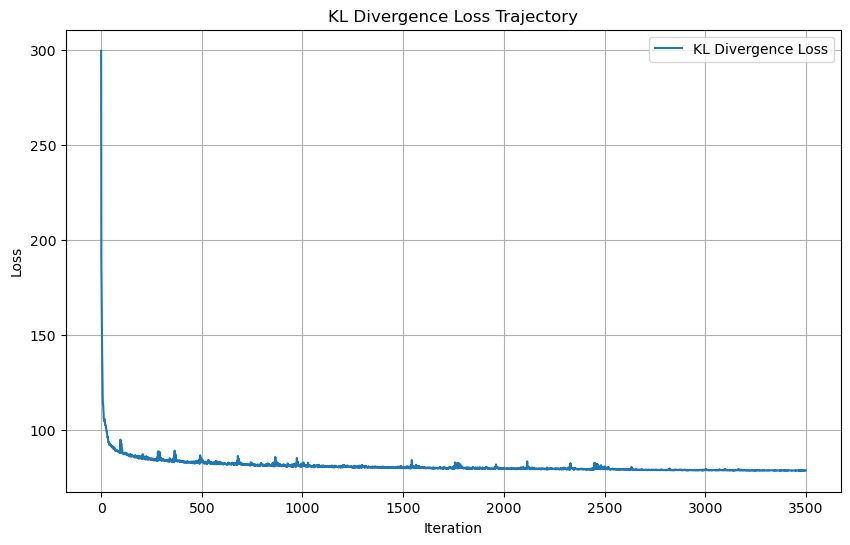

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='KL Divergence Loss')
plt.title('KL Divergence Loss Trajectory')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Generated 100/1000 samples
Generated 200/1000 samples
Generated 300/1000 samples
Generated 400/1000 samples
Generated 500/1000 samples
Generated 600/1000 samples
Generated 700/1000 samples
Generated 800/1000 samples
Generated 900/1000 samples
Generated 1000/1000 samples


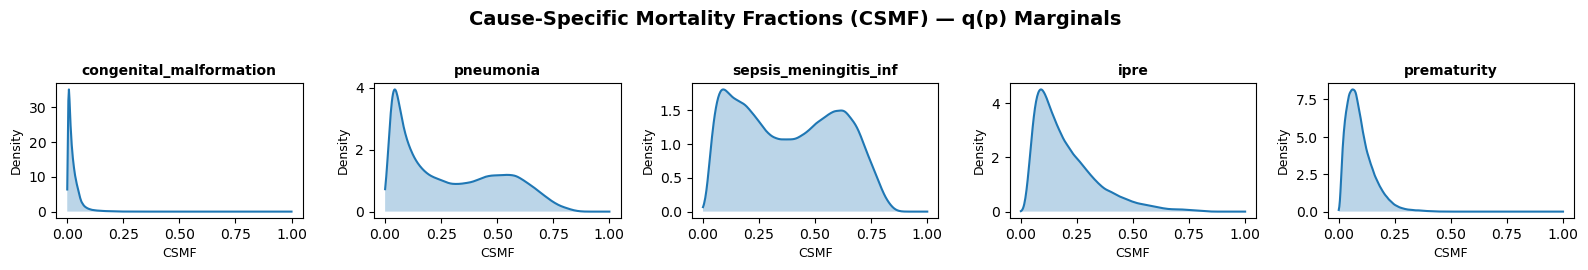

In [ ]:
# ─────────────────────────────────────────────────────────────
# Marginal samples from q(p)
# ─────────────────────────────────────────────────────────────
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

n_iterations = 1000
p_samples = get_marginal_samples(model, M_context, n_iterations=n_iterations)
p_samples_flat = p_samples.reshape(-1, K).cpu().numpy()

samples = p_samples_flat

if population == "neonate":
    dimension_names = ["congenital_malformation", "pneumonia", "sepsis_meningitis_inf", "ipre", "prematurity"]
else:
    dimension_names = ["malaria", "pneumonia", "diarrhea", "severe_malnutrition", "hiv", "injury", "other_infections", "nn_causes"]

df_samples = pd.DataFrame(samples, columns=dimension_names)
df_long = df_samples.melt(var_name="Cause", value_name="Value")

n_cols = 5
n_rows = math.ceil(K / n_cols)

plt.figure(figsize=(3.2 * n_cols, 2.6 * n_rows))
for j, col in enumerate(df_samples.columns, start=1):
    ax = plt.subplot(n_rows, n_cols, j)
    vals = df_samples[col].to_numpy()

    xs = np.linspace(0.0, 1.0, 400)
    try:
        kde = gaussian_kde(vals)
        ys = kde(xs)
        ax.plot(xs, ys)
        ax.fill_between(xs, ys, alpha=0.3)
    except Exception:
        ax.hist(vals, bins=40, density=True)

    ax.set_title(col, fontsize=10, fontweight="bold")
    ax.set_xlabel("CSMF", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)

plt.suptitle("Cause-Specific Mortality Fractions (CSMF) — q(p) Marginals", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()
